In [4]:
# !pip install geomloss
import os
import time
import torch
import cv2
import numpy as np
# from geomloss import SamplesLoss
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.transforms import transforms
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist
from scipy.io import loadmat

In [5]:
torch.manual_seed(42)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Model

In [7]:
convNext = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
convNext = convNext.to(device)


class ConvNext_Tiny_Backbone(nn.Module):

    def __init__(self):
        super().__init__()
    
    
    def forward(self, x):   
        x = convNext.features[0](x)
        x = convNext.features[1](x) # 96
        x = convNext.features[2](x)
        x = convNext.features[3](x) # 192
        F1 = x

        x = convNext.features[4](x)
        x = convNext.features[5](x) # 384
        F2 = x

        x = convNext.features[6](x)
        x = convNext.features[7](x) # 768
        F3 = x

        return F1, F2, F3

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 196MB/s] 


In [8]:
class FocusTransitionModule(nn.Module):
    """
    Implements the Focus Transition Module (FTM) with channel feature weight
    optimization, a simple convolution, and spatial feature weight optimization.
    No dynamic convolution or stacking is used for the convolution part.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Channel-wise attention (C(F) in Equation 3)
        self.channel_fc1 = nn.Linear(in_channels, in_channels // 4)
        self.channel_relu = nn.ReLU()
        self.channel_fc2 = nn.Linear(in_channels // 4, in_channels)
        self.channel_sigmoid = nn.Sigmoid()

        # Simple Convolution (replaces dynamic convolution and stacking)
        # This layer transforms the input channels (from F_prime) to out_channels
        self.simple_conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 2, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        # Spatial feature weight optimization (S(P) in Equation 5)
        # Input to spatial_conv is always 1 channel after torch.mean(P, dim=1, keepdim=True)
        self.spatial_conv = nn.Conv2d(1, 1, kernel_size=1)
        self.spatial_sigmoid = nn.Sigmoid()

        # Final BatchNorm and ReLU (applied to the output S)
        self.final_bn = nn.BatchNorm2d(out_channels)
        self.final_relu = nn.ReLU()

    def forward(self, x):
        # Input F (x)

        # Channel feature weight optimization C(F)
        avg_pool = F.adaptive_avg_pool2d(x, (1, 1)).squeeze(-1).squeeze(-1) # Global Average Pooling
        channel_attention = self.channel_fc2(self.channel_relu(self.channel_fc1(avg_pool))).unsqueeze(-1).unsqueeze(-1)
        channel_attention = self.channel_sigmoid(channel_attention)
        F_prime = x * channel_attention # Element-wise multiplication

        # Simple Convolution part
        # F_prime has 'in_channels'. Pass through simple conv to get 'out_channels'.
        P = self.simple_conv(F_prime)

        # Spatial feature weight optimization S(P)
        mean_P = torch.mean(P, dim=1, keepdim=True) # Mean value of P across channel dimension (output is 1 channel)
        spatial_attention = self.spatial_sigmoid(self.spatial_conv(mean_P))
        S = P * spatial_attention # Element-wise multiplication

        # Final BatchNorm and ReLU (applied to the output S)
        S = self.final_relu(self.final_bn(S))

        return S

In [9]:
class MultiScaleFusion(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.transpose2 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
        self.transpose3 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=4)

    
    def forward(self, s1, s2, s3):
        h, w = s1.shape[2], s1.shape[3]
        s2 = self.transpose2(s2)
        s3 = self.transpose3(s3)

        S = torch.cat([s1, s2, s3], dim=1)

        return S

In [10]:
class FFNet(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.backbone = ConvNext_Tiny_Backbone()
        self.focus1 = FocusTransitionModule(192, 16)
        self.focus2 = FocusTransitionModule(384, 32)
        self.focus3 = FocusTransitionModule(768, 64)
        self.fusion = MultiScaleFusion()

        self.conv = nn.Conv2d(112, 1, kernel_size=1)
    

    def forward(self, x):

        f1, f2, f3 = self.backbone(x)

        s1 = self.focus1(f1)
        s2 = self.focus2(f2)
        s3 = self.focus3(f3)

        S = self.fusion(s1, s2, s3)

        density_map = self.conv(S)

        return density_map

In [8]:
model = FFNet()
model = model.to(device)

# Dataset Pipeline

In [11]:
k_nearest = 3
beta = 0.3

def generate_density_map(img, points):

    img_width, img_height = img.size
    d_map_height = img_height // 8
    d_map_width = img_width // 8
    density_map = np.zeros((d_map_height, d_map_width), dtype=np.float32)
    
    if len(points) == 0:
        return density_map

    scaled_points = points / 8
    
    sigmas = []
    if len(scaled_points) > 1:
        distances = cdist(scaled_points, scaled_points)
        
        for i in range(len(scaled_points)):
            sorted_distances = np.sort(distances[i][distances[i] > 1e-6])
            
            if len(sorted_distances) >= k_nearest:
                d_k = sorted_distances[k_nearest - 1]
                sigma_i = beta * d_k
            else:
                sigma_i = beta * np.mean(sorted_distances) if len(sorted_distances) > 0 else 1.0
            sigmas.append(sigma_i)
    else:
        sigmas.append(4.0)
    
    sigmas = np.array(sigmas)
    
    for i, (x, y) in enumerate(scaled_points):
        if int(y) < d_map_height and int(x) < d_map_width:
            point_map = np.zeros_like(density_map)
            point_map[int(y), int(x)] = 1.0
            
            blurred_point_map = gaussian_filter(point_map, sigma=sigmas[i], mode='constant')

            density_map += blurred_point_map
    
    return density_map

In [12]:
class CustomDataset(Dataset):

    def __init__(self, img_folder_path, point_folder_path):
        self.img_folder_path = img_folder_path
        self.point_folder_path = point_folder_path
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


    def __len__(self):
        return(len(os.listdir(self.img_folder_path)))


    def __getitem__(self, index):
        img_path = os.path.join(self.img_folder_path, f"IMG_{index+1}.jpg")
        point_path = os.path.join(self.point_folder_path, f"GT_IMG_{index+1}.mat")

        img = Image.open(img_path).convert("RGB")

        data = loadmat(point_path)
        point = data["image_info"][0][0][0][0][0]

        density_map = generate_density_map(img, points=point.astype(int))
        density_map = torch.from_numpy(density_map).float().unsqueeze(0)

        img = self.transform(img)

        return img, density_map

In [13]:
train_dataset = CustomDataset("/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/images", "/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/ground_truth")
test_dataset = CustomDataset("/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/images", "/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/ground_truth")

In [14]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

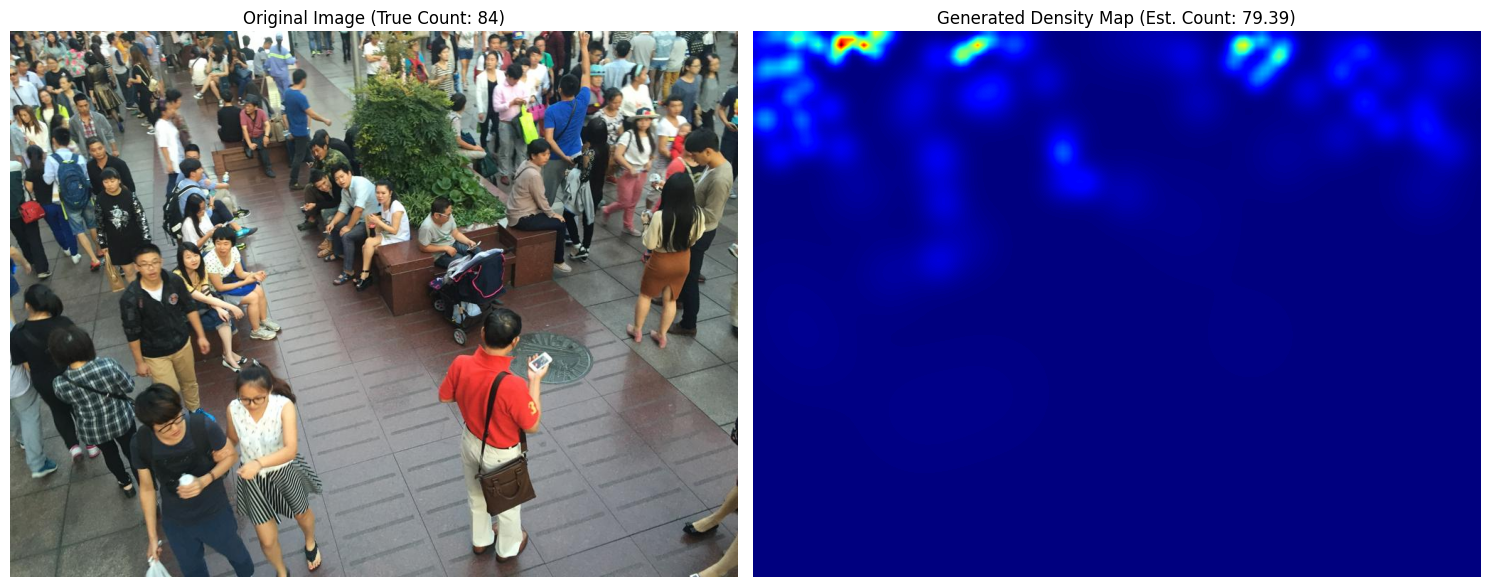

In [15]:
data = loadmat('/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/ground_truth/GT_IMG_40.mat')
point = data["image_info"][0][0][0][0][0]


img = Image.open("/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/images/IMG_40.jpg").convert("RGB")

density_map = generate_density_map(img, points=point.astype(int))
density_map_tensor = torch.from_numpy(density_map).float().unsqueeze(0).unsqueeze(0)

upsampled_density_map = torch.nn.functional.interpolate(
    density_map_tensor,
    size=(img.size[1], img.size[0]),
    mode='bilinear',
    align_corners=False).squeeze().cpu().numpy()


true_count = len(point)
estimated_count = np.sum(density_map)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f'Original Image (True Count: {true_count})')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(upsampled_density_map, cmap='jet')
plt.title(f'Generated Density Map (Est. Count: {estimated_count:.2f})')
plt.axis('off')

plt.tight_layout()
plt.show()

# Loss Fxn

In [ ]:
class LossFxn(nn.Module):

    def __init__(self, lambda1 = 0.1, lambda2 = 0.01):

        super(LossFxn, self).__init__()

        self.lambda1 = lambda1
        self.lambda2 = lambda2

        ot_params = {'loss': 'sinkhorn', 'p': 2, 'blur': 10, 'debias': True}

        self.ot_loss_fxn = SamplesLoss(**ot_params)
        self.variational_loss = nn.L1Loss()


    def forward(self, y_true, y_pred):

        B, _, H, W = y_pred.shape

        pred_flat = y_pred.view(B, -1) + 1e-8
        true_flat = y_true.view(B, -1) + 1e-8

        pred_dist_norm = pred_flat / pred_flat.sum(dim=1, keepdim=True)
        true_dist_norm = true_flat / true_flat.sum(dim=1, keepdim=True)

        coords_x = torch.arange(W, device=y_pred.device, dtype=y_pred.dtype)
        coords_y = torch.arange(H, device=y_pred.device, dtype=y_pred.dtype)
        
        grid_x, grid_y = torch.meshgrid(coords_x, coords_y, indexing='ij')
        pixel_coords = torch.stack((grid_x.flatten(), grid_y.flatten()), dim=-1)
        pixel_coords_batch = pixel_coords.unsqueeze(0).repeat(B, 1, 1)
        
        ot_loss = self.ot_loss_fxn(pred_dist_norm, pixel_coords_batch, true_dist_norm, pixel_coords_batch)

        count_loss = self.variational_loss(y_true.sum(dim=[1, 2, 3]), y_pred.sum(dim=[1, 2, 3])) / B
        variational_loss = self.variational_loss(y_pred, y_true) / B

        total_loss = count_loss + (self.lambda1 * ot_loss) + (self.lambda2 * variational_loss)

        return total_loss

In [17]:
learning_rate = 0.0001
epochs = 1

loss_fxn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop

In [ ]:
start = time.time()
model.train()
losses = []


for i in range(epochs):

    total_epoch_loss = 0
    count = 0

    for batch_image, batch_density_map in train_loader:

        batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

        output = model(batch_image)

        loss = loss_fxn(output, batch_density_map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        print(f"Batch No.: {count}, Time Elapsed: {(time.time() - start):.1f}, Loss: {loss.item():.5f}")
    
        total_epoch_loss += loss.item()
        losses.append(loss.item())

    avg_epoch_loss = total_epoch_loss / len(train_loader)
    print(f"Epoch: {i+1}, Loss: {avg_epoch_loss}")        

In [ ]:
plt.plot(range(1, 505), losses)
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model_weights_SimplifiedFFNet12.pth')

In [16]:
model = FFNet()
model = model.to(device)
model.load_state_dict(torch.load('/kaggle/input/simplifiedffnet12/pytorch/default/1/model_weights_SimplifiedFFNet12.pth'))

<All keys matched successfully>

# Evaluation

In [18]:
model.eval()

FFNet(
  (backbone): ConvNext_Tiny_Backbone()
  (focus1): FocusTransitionModule(
    (channel_fc1): Linear(in_features=192, out_features=48, bias=True)
    (channel_relu): ReLU()
    (channel_fc2): Linear(in_features=48, out_features=192, bias=True)
    (channel_sigmoid): Sigmoid()
    (simple_conv): Sequential(
      (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
      (1): ReLU(inplace=True)
      (2): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
      (3): ReLU(inplace=True)
      (4): Conv2d(192, 96, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
      (5): ReLU(inplace=True)
      (6): Conv2d(96, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
      (7): ReLU(inplace=True)
    )
    (spatial_conv): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
    (spatial_sigmoid): Sigmoid()
    (final_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_ru

In [19]:
eval_metric = nn.L1Loss()

In [20]:
total_loss = 0
total_mae = 0
total_mse = 0
count = 0

for batch_image, batch_density_map in test_loader:

    batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

    with torch.no_grad():
        output = model(batch_image)

    loss = eval_metric(output, batch_density_map)

    predicted_counts = output.sum(dim=[1, 2, 3])
    true_counts = batch_density_map.sum(dim=[1, 2, 3])

    abs_diff = torch.abs(predicted_counts - true_counts)
    squared_diff = (predicted_counts - true_counts) ** 2
    
    total_mae += torch.sum(abs_diff).item()
    total_mse += torch.sum(squared_diff).item()

    count += 1
    print(f"Batch No.: {count}, Loss: {loss.item()}")

    total_loss += loss.item()

avg_loss = total_loss / (len(test_loader))
avg_mae = total_mae / (len(test_loader) * batch_size)
avg_mse = total_mse / (len(test_loader) * batch_size)

print(f"Avg Loss: {avg_loss}") 
print(f"Avg MAE: {avg_mae}")
print(f"Avg MSE: {avg_mse}")

Batch No.: 1, Loss: 0.0028351831715554
Batch No.: 2, Loss: 0.006162039935588837
Batch No.: 3, Loss: 0.008182103745639324
Batch No.: 4, Loss: 0.004920545965433121
Batch No.: 5, Loss: 0.006748054176568985
Batch No.: 6, Loss: 0.0028984560631215572
Batch No.: 7, Loss: 0.004846545867621899
Batch No.: 8, Loss: 0.004853173159062862
Batch No.: 9, Loss: 0.005166101735085249
Batch No.: 10, Loss: 0.014053087681531906
Batch No.: 11, Loss: 0.0034086965024471283
Batch No.: 12, Loss: 0.004763467237353325
Batch No.: 13, Loss: 0.004535275977104902
Batch No.: 14, Loss: 0.009014289826154709
Batch No.: 15, Loss: 0.005218298640102148
Batch No.: 16, Loss: 0.0036044928710907698
Batch No.: 17, Loss: 0.004727731458842754
Batch No.: 18, Loss: 0.0046335551887750626
Batch No.: 19, Loss: 0.008222678676247597
Batch No.: 20, Loss: 0.008522963151335716
Batch No.: 21, Loss: 0.003905022516846657
Batch No.: 22, Loss: 0.005106158554553986
Batch No.: 23, Loss: 0.004775041714310646
Batch No.: 24, Loss: 0.005254708230495453

In [21]:
total_loss = 0
total_mae = 0
total_mse = 0
count = 0

for batch_image, batch_density_map in train_loader:

    batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

    with torch.no_grad():
        output = model(batch_image)

    loss = eval_metric(output, batch_density_map)

    predicted_counts = output.sum(dim=[1, 2, 3])
    true_counts = batch_density_map.sum(dim=[1, 2, 3])

    abs_diff = torch.abs(predicted_counts - true_counts)
    squared_diff = (predicted_counts - true_counts) ** 2
    
    total_mae += torch.sum(abs_diff).item()
    total_mse += torch.sum(squared_diff).item()

    count += 1
    print(f"Batch No.: {count}, Loss: {loss.item()}")

    total_loss += loss.item()

avg_loss = total_loss / (len(train_loader))
avg_mae = total_mae / (len(train_loader) * batch_size)
avg_mse = total_mse / (len(train_loader) * batch_size)

print(f"Avg Loss: {avg_loss}")
print(f"Avg MAE: {avg_mae}")
print(f"Avg MSE: {avg_mse}")

Batch No.: 1, Loss: 0.005899197421967983
Batch No.: 2, Loss: 0.007449237164109945
Batch No.: 3, Loss: 0.0033128901850432158
Batch No.: 4, Loss: 0.0040884558111429214
Batch No.: 5, Loss: 0.006513121537864208
Batch No.: 6, Loss: 0.005864129867404699
Batch No.: 7, Loss: 0.004953460767865181
Batch No.: 8, Loss: 0.002856549574062228
Batch No.: 9, Loss: 0.006256083957850933
Batch No.: 10, Loss: 0.004548743367195129
Batch No.: 11, Loss: 0.003547693369910121
Batch No.: 12, Loss: 0.004677390214055777
Batch No.: 13, Loss: 0.003636938286945224
Batch No.: 14, Loss: 0.004490254446864128
Batch No.: 15, Loss: 0.004995118360966444
Batch No.: 16, Loss: 0.004903588443994522
Batch No.: 17, Loss: 0.0034612100571393967
Batch No.: 18, Loss: 0.004542679991573095
Batch No.: 19, Loss: 0.0033744852989912033
Batch No.: 20, Loss: 0.004098690114915371
Batch No.: 21, Loss: 0.004246978089213371
Batch No.: 22, Loss: 0.003714887425303459
Batch No.: 23, Loss: 0.004543139599263668
Batch No.: 24, Loss: 0.0029188632033765

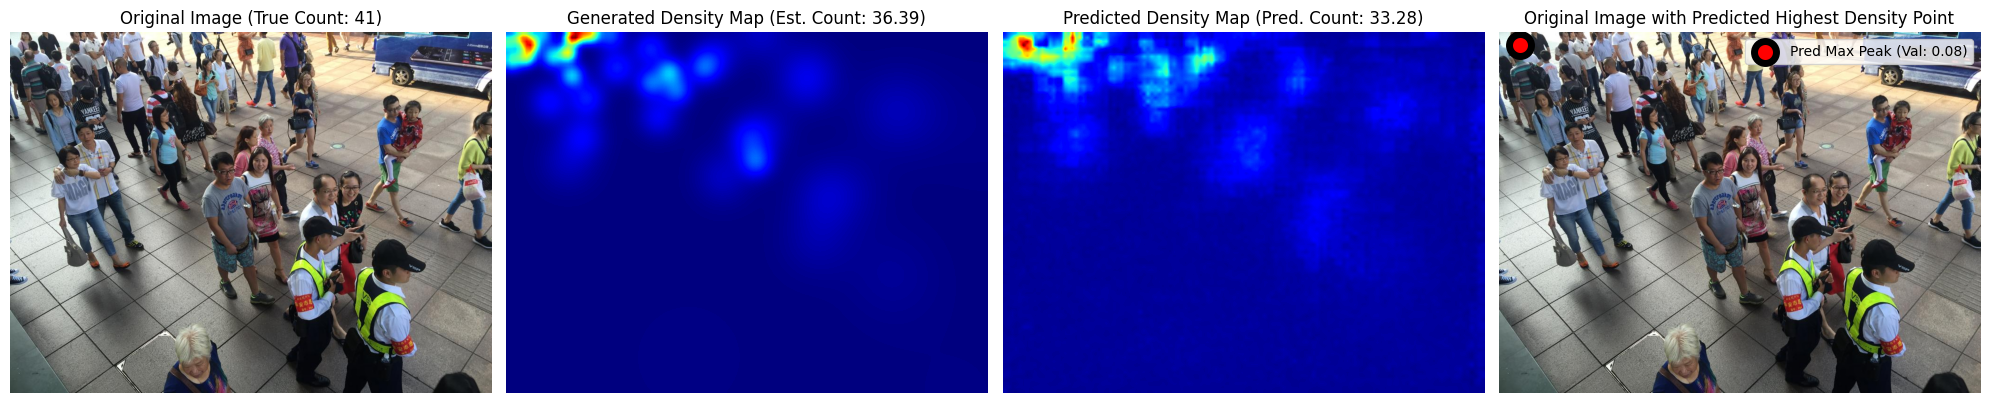

In [23]:
from scipy.ndimage import maximum_filter


data = loadmat('/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/ground_truth/GT_IMG_42.mat')
point = data["image_info"][0][0][0][0][0]


img = Image.open("/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/images/IMG_42.jpg").convert("RGB")
width, height = img.size

density_map = generate_density_map(img, points=point.astype(int))
density_map_tensor = torch.from_numpy(density_map).float().unsqueeze(0).unsqueeze(0)
upsampled_density_map = torch.nn.functional.interpolate(
    density_map_tensor,
    size=(img.size[1], img.size[0]),
    mode='bilinear',
    align_corners=False).squeeze().cpu().numpy()


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
with torch.no_grad():
    img_ = transform(img)
    img_ = img_.to(device)
    predicted_density_map = model(img_.unsqueeze(0))
    upsampled_predicted_density_map = torch.nn.functional.interpolate(
        predicted_density_map,
        size=(height, width),
        mode='bilinear',
        align_corners=False).squeeze().cpu().numpy()


true_count = len(point)
estimated_count = np.sum(density_map)
predicted_count = predicted_density_map.sum().item()


max_pred_density_value = np.max(upsampled_predicted_density_map)
max_pred_density_coords_flat = np.argmax(upsampled_predicted_density_map)
max_pred_density_peak_row, max_pred_density_peak_col = np.unravel_index(
    max_pred_density_coords_flat, upsampled_predicted_density_map.shape
)


plt.figure(figsize=(20, 6))

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title(f'Original Image (True Count: {true_count})')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(upsampled_density_map, cmap='jet')
plt.title(f'Generated Density Map (Est. Count: {estimated_count:.2f})')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(upsampled_predicted_density_map, cmap='jet')
plt.title(f'Predicted Density Map (Pred. Count: {predicted_count:.2f})')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(img)
plt.scatter(max_pred_density_peak_col, max_pred_density_peak_row, 
            color='red', s=1000, marker='.', edgecolors='black', linewidth=5, 
            label=f'Pred Max Peak (Val: {max_pred_density_value:.2f})')
plt.title(f'Original Image with Predicted Highest Density Point')
plt.axis('off')
plt.legend()

plt.tight_layout()
plt.show()